### Thermal Shift Western LL4 Models

LL4 model fits and plots for thermal shift western data obtained from WT and TYK2-P1104A cell lines:

  -  [Raw Data](../validation/20240404_bulk_TSA_data.tsv)
  -  [LL4 Parameters](../validation/20240404_bulk_TSA_ll4_parameters.tsv)

In [2]:
library(ggpubr)
library(drc)
library(ggbeeswarm)
library(broom)
library(patchwork)
library(tidyverse)

ll4 <- function(slope, emin, emax, ec50, x) {
  value <- emin + ((emax - emin) / (1 + exp(slope * (log(x) - log(ec50)))))
  return(value)
}

plot_assay <- function(df, params, title){

    df_wt <- df %>% filter(Variant == "WT")
    df_p1104a <- df %>% filter(Variant == "P1104A")
    
    the_plot <- ggplot() +
        geom_point(data = df_wt,
                   aes(x = Temperature,
                       y = `Area TYK2`),
                   color = "black") +
        geom_point(data = df_p1104a,
                   aes(x = Temperature,
                       y = `Area TYK2`),
                   color = "red") +
        stat_function(fun = ll4,
                      args = list(slope = params$b[1],
                                  emin = params$c[1],
                                  emax = params$d[1],
                                  ec50 = params$e[1]), color = "black") +
        stat_function(fun = ll4,
                      args = list(slope = params$b[2],
                                  emin = params$c[2],
                                  emax = params$d[2],
                                  ec50 = params$e[2]), color = "red") +
        ggtitle(title) +
        theme_pubr(base_size = 20) +
        geom_vline(xintercept = params$e, color = c("black", "red"))
    
    return(the_plot)
}

In [3]:
raw_data <- read_tsv("../validation/20240404_bulk_TSA_data.tsv")

drc_models <- drm(tibble(raw_data$`Area TYK2`,
           raw_data$Temperature),
    curveid = str_c(raw_data$Run, "_", raw_data$Variant),
    fct = LL.4())

drc_params <- drc_models %>%
    tidy() %>%
    select(term, curve, estimate) %>%
    pivot_wider(names_from = term, values_from = estimate) %>%
    separate(curve, c("Run", "Variant"), "_") %>%
    mutate(Run = as.numeric(Run)) %>%
    nest(coefs = -Run)

data_with_params <- raw_data %>%
    nest(data = -Run) %>%
    inner_join(drc_params)

all_plots <- pmap(.l = list(data_with_params$data,
               data_with_params$coefs,
               str_c("Run ", data_with_params$Run)),
     .f = plot_assay)

Rows: 192 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Variant
dbl (4): Temperature, Run, Area TYK2, Area GAPDH

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Run)`


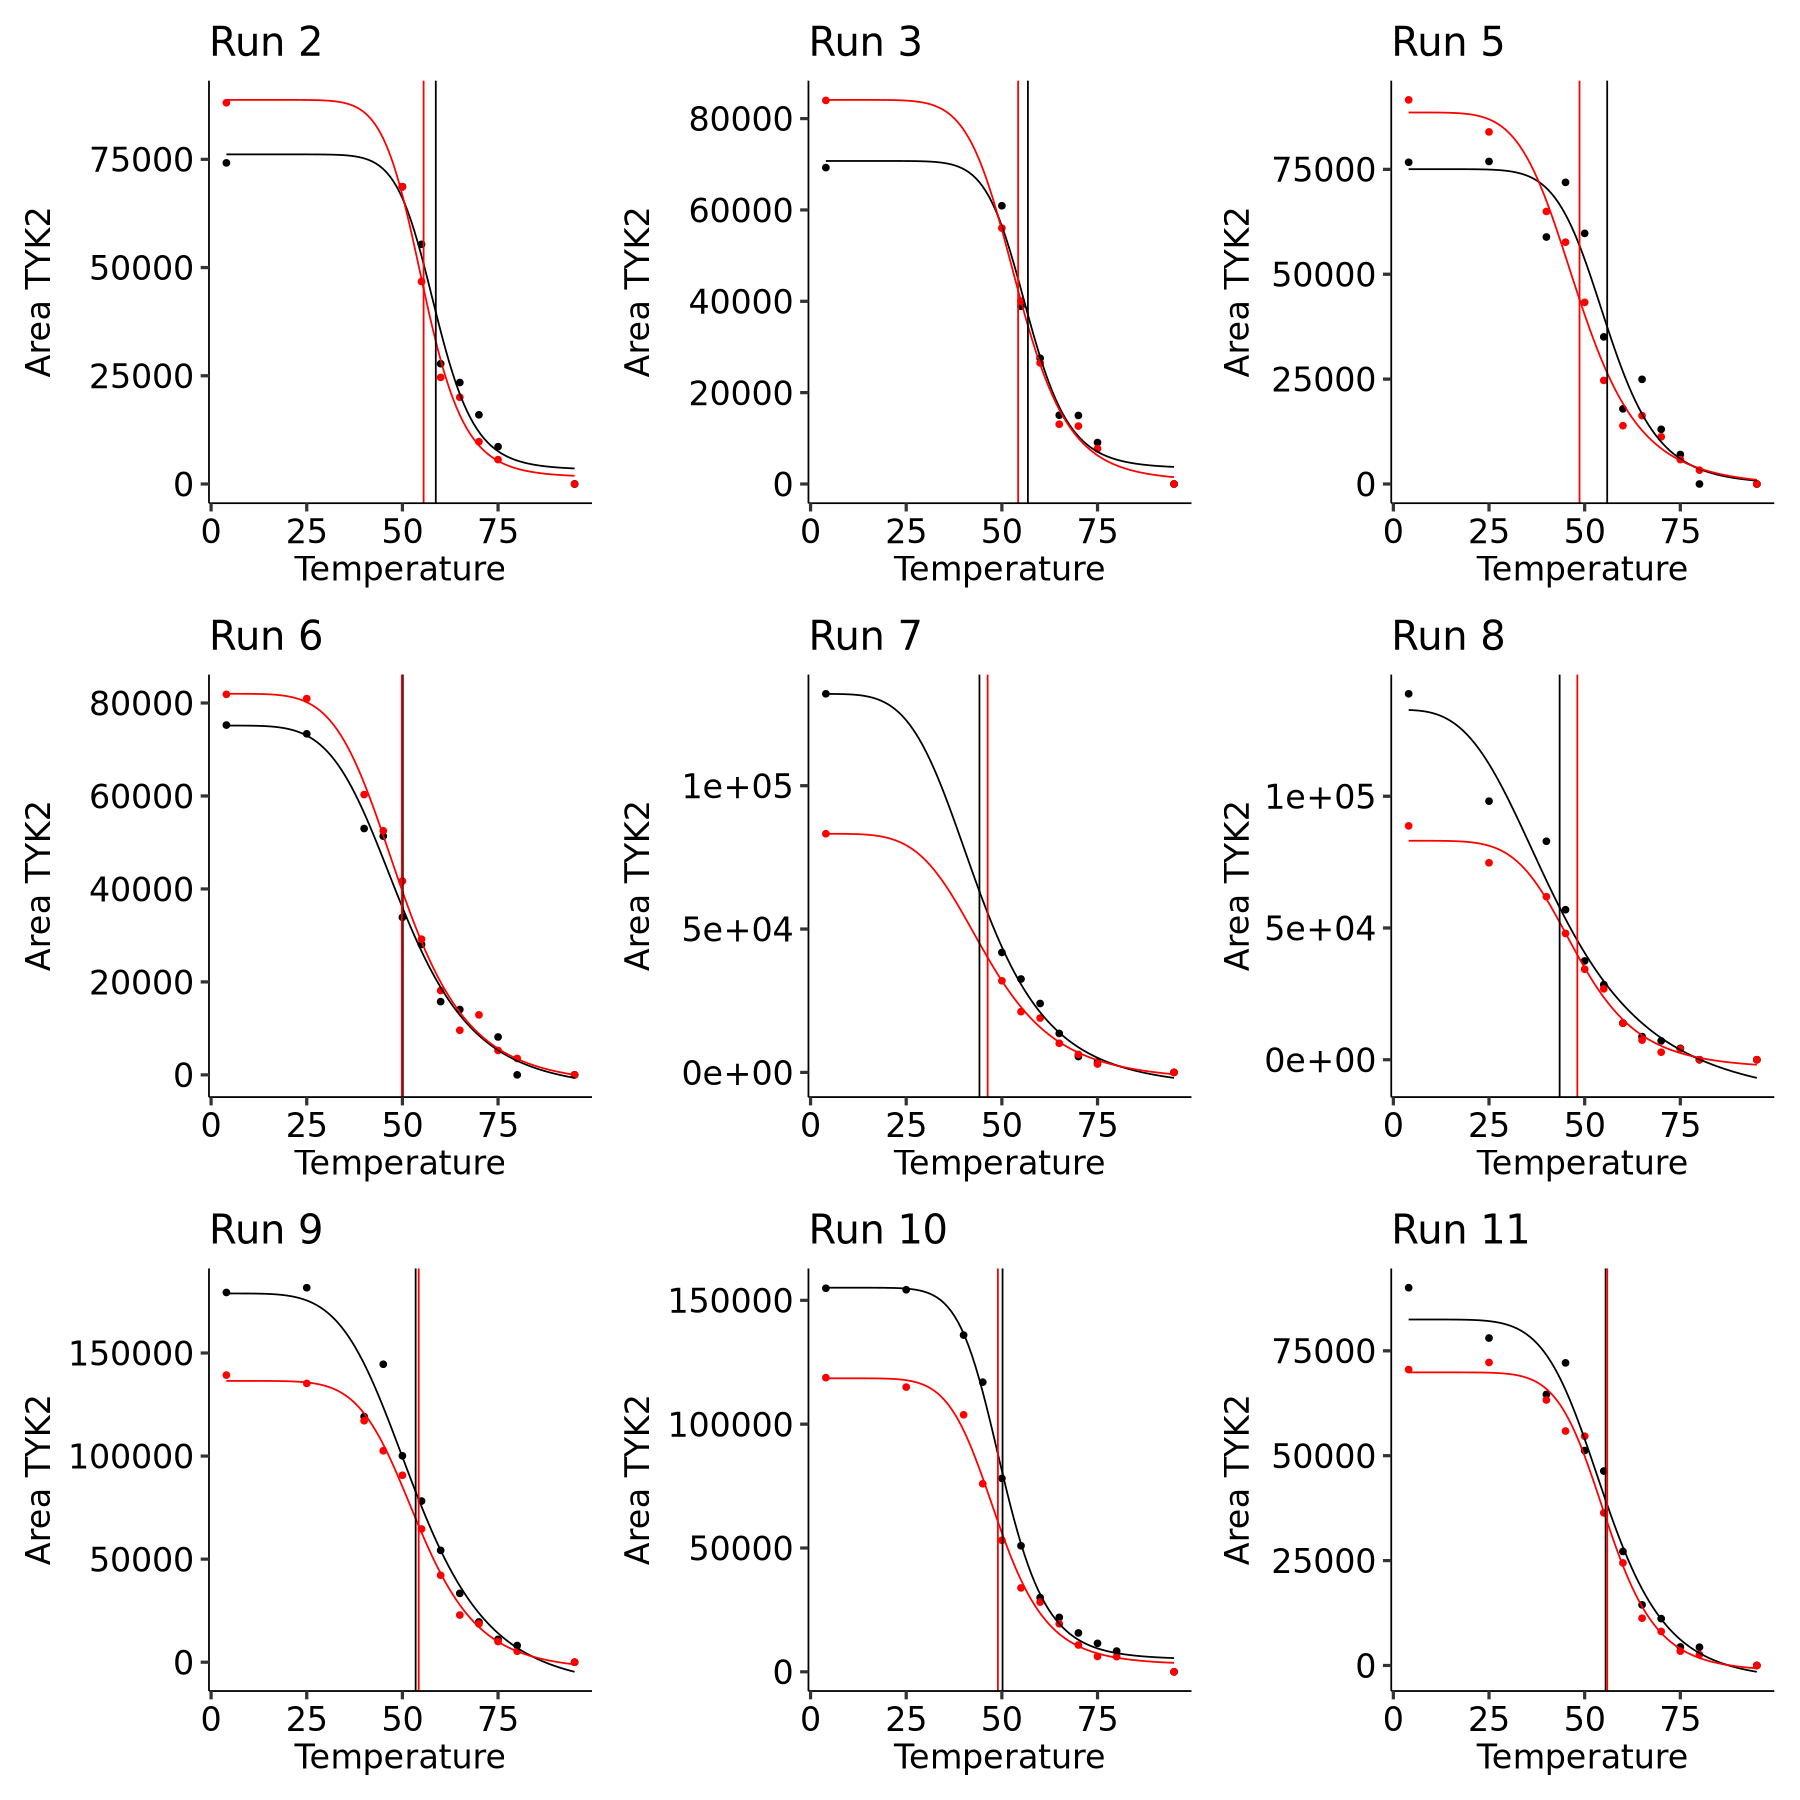

In [4]:
options(repr.plot.width = 15, repr.plot.height = 15, warn = -1)
wrap_plots(all_plots)

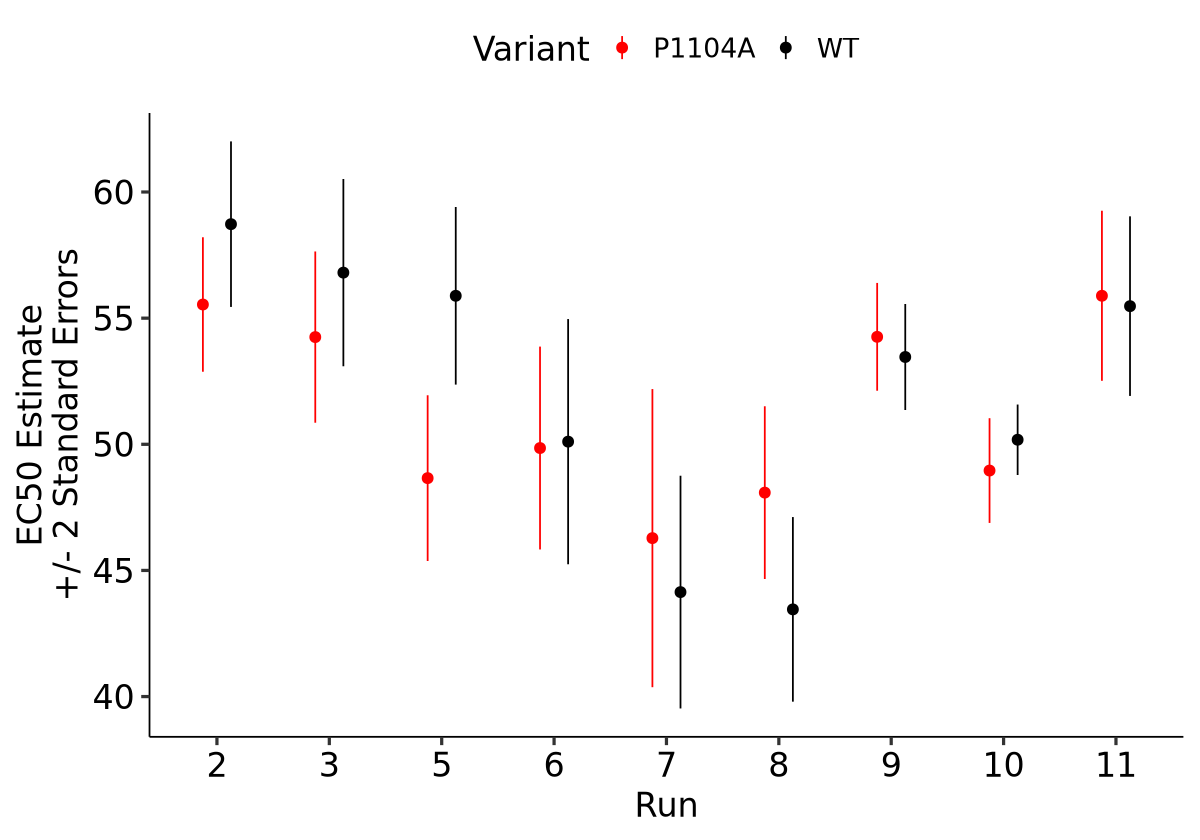

In [5]:
options(repr.plot.width = 10, repr.plot.height = 7)
tidy(drc_models) %>%
    filter(term == "e") %>%
    select(estimate, std.error, curve) %>%
    separate(curve, c("Run", "Variant"), "_") %>%
    ggplot() + 
        geom_pointrange(aes(x = reorder(Run, as.numeric(Run)),
                            y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error,
                            color = Variant),
                        position = position_dodge(width = 0.5)) +
        theme_pubr(base_size = 20) +
        scale_color_manual(values = c("WT" = "black", "P1104A" = "red")) +
        xlab("Run") + ylab("EC50 Estimate\n+/- 2 Standard Errors")

In [9]:
drc_params %>%
    unnest() %>%
    rename("Slope" = "b",
           "Emin" = "c",
           "Emax" = "d",
           "EC50" = "e") %>%
    write_tsv("../validation/20240404_bulk_TSA_ll4_parameters.tsv")